In [2]:
# Import the required libraries
import os  # For handling file system paths
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns  # For enhanced data visualization
import tensorflow as tf  # For deep learning and neural network implementation
from sklearn.model_selection import train_test_split  # For splitting datasets into training and test sets
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve  # For evaluating model performance
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For augmenting image data
from tensorflow.keras.applications import ResNet50  # For loading the pre-trained ResNet50 model
from tensorflow.keras.applications.resnet50 import preprocess_input  # For preprocessing input data to fit ResNet50's requirements
from tensorflow.keras import layers, models  # For building and customizing neural network architectures
from tensorflow.keras.models import Model  # For creating customized models
from tensorflow.keras.losses import CategoricalCrossentropy  # For defining the loss function for multi-class classification
from tensorflow.keras.callbacks import ModelCheckpoint  # For saving the best model during training
import keras_tuner as kt  # For hyperparameter tuning using Keras Tuner

In [3]:
metadata_path = r"C:\\Users\\marti\\Desktop\\dom\\Data\\metadata_f1.csv"  # Path to the metadata file (CSV format)
image_dir = r"C:\\Users\\marti\\Desktop\\dom\\Data"  # Directory containing the image dataset

In [4]:
# Load the metadata into a pandas DataFrame
data = pd.read_csv(metadata_path)  # Reads the CSV file containing metadata into a DataFrame

# Display a preview of the data
print("Data Preview:", data.head())  # Prints the first few rows of the DataFrame to inspect its structure

Data Preview:         isic_id diagnosis  age_approx
0  ISIC_0024306     nevus        45.0
1  ISIC_0024307     nevus        50.0
2  ISIC_0024308     nevus        55.0
3  ISIC_0024309     nevus        40.0
4  ISIC_0024310  melanoma        60.0


In [5]:
# Add a 'filename' column based on the 'isic_id' column
data['filename'] = data['isic_id'] + ".jpg"  # Appends the '.jpg' extension to each value in the 'isic_id' column

# Display the first few rows to verify the changes
print("Data preview after adding 'filename':", data.head())  # Prints the updated DataFrame with the new 'filename' column


Data preview after adding 'filename':         isic_id diagnosis  age_approx          filename
0  ISIC_0024306     nevus        45.0  ISIC_0024306.jpg
1  ISIC_0024307     nevus        50.0  ISIC_0024307.jpg
2  ISIC_0024308     nevus        55.0  ISIC_0024308.jpg
3  ISIC_0024309     nevus        40.0  ISIC_0024309.jpg
4  ISIC_0024310  melanoma        60.0  ISIC_0024310.jpg


In [6]:
# --- Step 3: Split the data ---
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['diagnosis'])


In [7]:
# --- Step 4: Data Augmentation ---
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_gen.flow_from_dataframe(
    dataframe=train_data,
    directory=image_dir,
    x_col='filename',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = data_gen.flow_from_dataframe(
    dataframe=test_data,
    directory=image_dir,
    x_col='filename',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 9376 validated image filenames belonging to 8 classes.
Found 2344 validated image filenames belonging to 8 classes.


In [8]:
# Récupérer les indices des classes à partir du générateur
class_indices = train_generator.class_indices

# Inverser les indices de classe pour obtenir un dictionnaire {indice: label}
class_labels = {v: k for k, v in class_indices.items()}

# Afficher les indices et les labels associés
print("Indices de classes et leurs labels correspondants :")
for index, label in class_labels.items():
    print(f"Indice {index}: {label}")


Indices de classes et leurs labels correspondants :
Indice 0: actinic keratosis
Indice 1: basal cell carcinoma
Indice 2: dermatofibroma
Indice 3: melanoma
Indice 4: nevus
Indice 5: pigmented benign keratosis
Indice 6: squamous cell carcinoma
Indice 7: vascular lesion


In [9]:
# --- Step 2: Count Images per Label ---
label_counts = data['diagnosis'].value_counts()
print("\nNumber of images per label:")
print(label_counts)


Number of images per label:
nevus                         7737
pigmented benign keratosis    1338
melanoma                      1305
basal cell carcinoma           622
squamous cell carcinoma        229
vascular lesion                180
dermatofibroma                 160
actinic keratosis              149
Name: diagnosis, dtype: int64


In [10]:
# --- Step 5: Build the Model ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(len(label_counts), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
#Train the Model with Checkpoints ---
base_dir = os.getcwd()  # Base directory
model_save_path = r"C:\\Users\\marti\\Desktop\\dom\\best_model.h5"  # Path to save the best model

# Callback to save the best checkpoints
checkpoint = ModelCheckpoint(
    model_save_path,  # Save the model at this path
    monitor='val_accuracy',  # Monitor validation accuracy for saving the best model
    save_best_only=True,  # Only save the model if it improves
    verbose=1  # Print updates when saving the model
)

# Train the model
history = model.fit(
    train_generator,  # Training data generator
    epochs=20,  # Number of epochs to train
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpoint]  # Use the checkpoint callback to save the best model during training
)

# Save the final model after training
final_model_path = r"C:\\Users\\marti\\Desktop\\dom\\final_model.h5"  # Path to save the final model
model.save(final_model_path)  # Save the final model
print(f"Final model saved at {final_model_path}")  # Print confirmation


Epoch 1/20
293/293 [==============================] - ETA: 0s - loss: 0.9150 - accuracy: 0.7086
Epoch 1: val_accuracy improved from -inf to 0.74616, saving model to C:\\Users\\marti\\Desktop\\dom\best_model.h5
293/293 [==============================] - 704s 2s/step - loss: 0.9150 - accuracy: 0.7086 - val_loss: 0.7108 - val_accuracy: 0.7462
Epoch 2/20
293/293 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.7649
Epoch 2: val_accuracy did not improve from 0.74616
293/293 [==============================] - 652s 2s/step - loss: 0.6552 - accuracy: 0.7649 - val_loss: 0.7179 - val_accuracy: 0.7445
Epoch 3/20
293/293 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.7788
Epoch 3: val_accuracy improved from 0.74616 to 0.76280, saving model to C:\\Users\\marti\\Desktop\\dom\best_model.h5
293/293 [==============================] - 1105s 4s/step - loss: 0.6028 - accuracy: 0.7788 - val_loss: 0.6432 - val_accuracy: 0.7628
Epoch 4/20
293/293 [=============

In [12]:
# Evaluate the Model ---
print("\nEvaluating the model on test data...")
evaluation = model.evaluate(validation_generator)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


Evaluating the model on test data...
74/74 [==============================] - 118s 2s/step - loss: 0.5825 - accuracy: 0.8063
Test Loss: 0.5825498700141907, Test Accuracy: 0.8063139915466309


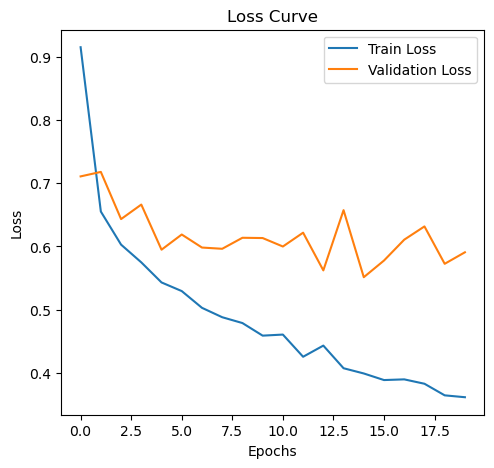

In [13]:
# --- Visualization of Loss and Accuracy Curves ---
history_df = pd.DataFrame(history.history)  # Convert history data into a DataFrame for easy access to metrics
plt.figure(figsize=(12, 5))  # Create a figure with specified size (12x5 inches)

# Loss curve
plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, position 1)
plt.plot(history_df['loss'], label='Train Loss')  # Plot training loss
plt.plot(history_df['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Loss Curve')  # Set title for the loss curve
plt.xlabel('Epochs')  # Label for the x-axis (Epochs)
plt.ylabel('Loss')  # Label for the y-axis (Loss)
plt.legend()  # Display the legend for the plot


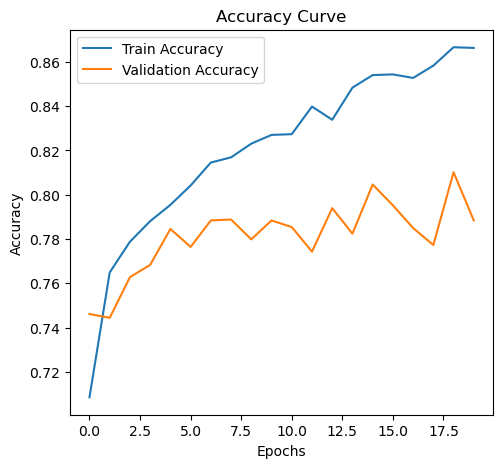

In [14]:
# --- Visualization of Loss and Accuracy Curves ---
history_df = pd.DataFrame(history.history)  # Convert history data into a DataFrame for easy access to metrics
plt.figure(figsize=(12, 5))  # Create a figure with specified size (12x5 inches)


# Accuracy curve
plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, position 2)
plt.plot(history_df['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Accuracy Curve')  # Set title for the accuracy curve
plt.xlabel('Epochs')  # Label for the x-axis (Epochs)
plt.ylabel('Accuracy')  # Label for the y-axis (Accuracy)
plt.legend()  # Display the legend for the plot

plt.show()  # Show the plot



Generating predictions...
74/74 [==============================] - 114s 2s/step

Generating confusion matrix...


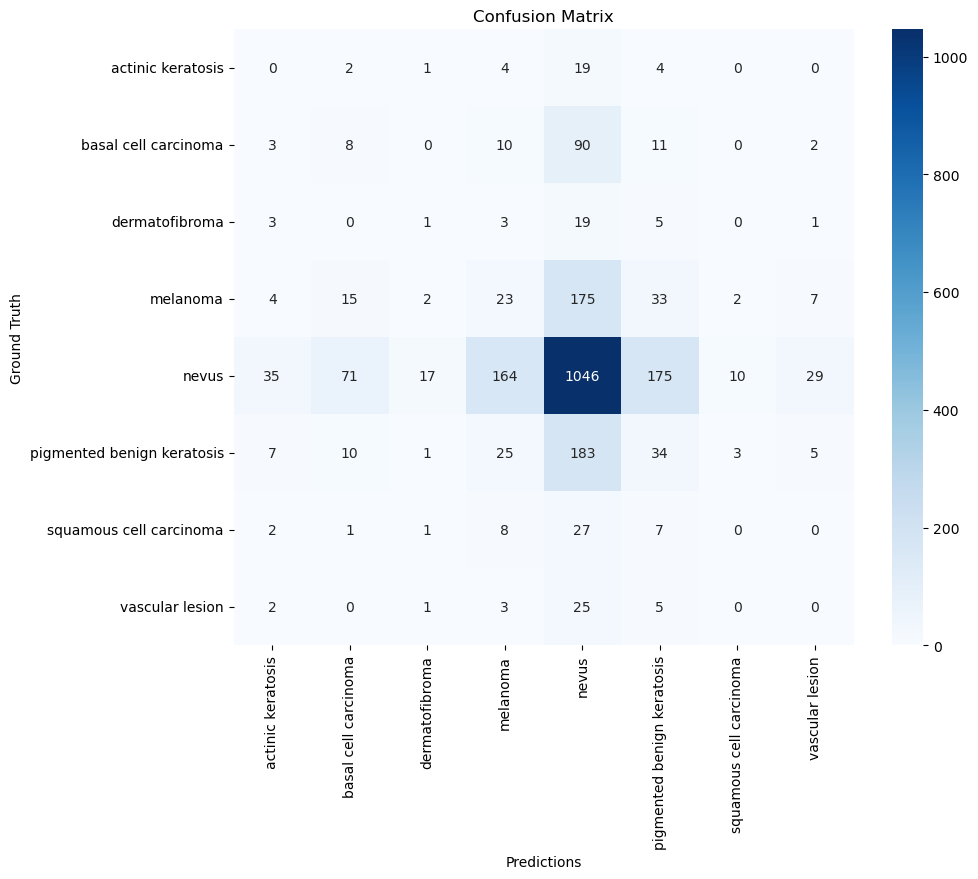

In [18]:
# --- Step 8: Predictions and Metrics ---
print("\nGenerating predictions...")

# Get true labels from validation generator
y_true = validation_generator.classes

# Predict the probabilities for the validation set
y_pred_probs = model.predict(validation_generator)

# Convert probabilities to class labels (use argmax for multi-class classification)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Confusion Matrix ---
print("\nGenerating confusion matrix...")

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix heatmap
plt.figure(figsize=(10, 8))  # Set figure size for better readability
sns.heatmap(
    cm,
    annot=True,  # Annotate cells with the numeric value
    fmt='d',  # Format annotations as integers
    cmap='Blues',  # Use blue color map for the heatmap
    xticklabels=validation_generator.class_indices.keys(),  # Use class names for x-ticks
    yticklabels=validation_generator.class_indices.keys()   # Use class names for y-ticks
)

plt.title("Confusion Matrix")  # Title of the plot
plt.xlabel("Predictions")  # X-axis label
plt.ylabel("Ground Truth")  # Y-axis label
plt.show()  # Show the plot

In [15]:
# --- Step 8: Predictions and Metrics ---
print("\nGenerating predictions...")
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)


Generating predictions...
74/74 [==============================] - 115s 2s/step


In [19]:
# IoU (Intersection over Union)
def calculate_iou(cm):
    iou_per_class = {}
    for i, class_name in enumerate(validation_generator.class_indices):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-7)
        iou_per_class[class_name] = iou
    return iou_per_class

iou_scores = calculate_iou(cm)
print("\nIoU Scores per class:")
for class_name, iou in iou_scores.items():
    print(f"{class_name}: {iou:.2f}")


IoU Scores per class:
actinic keratosis: 0.00
basal cell carcinoma: 0.04
dermatofibroma: 0.02
melanoma: 0.05
nevus: 0.50
pigmented benign keratosis: 0.07
squamous cell carcinoma: 0.00
vascular lesion: 0.00


In [20]:
# --- Step 9: Use Focal Loss ---
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        weight = self.alpha * tf.math.pow(1 - y_pred, self.gamma)
        return tf.reduce_sum(weight * ce, axis=-1)

# Re-compile with Focal Loss
model.compile(
    optimizer='adam',
    loss=FocalLoss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

print("\nRecompiled the model with Focal Loss.")


Recompiled the model with Focal Loss.


In [21]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.07      0.06      0.07       124
           2       0.04      0.03      0.04        32
           3       0.10      0.09      0.09       261
           4       0.66      0.68      0.67      1547
           5       0.12      0.13      0.13       268
           6       0.00      0.00      0.00        46
           7       0.00      0.00      0.00        36

    accuracy                           0.47      2344
   macro avg       0.12      0.12      0.12      2344
weighted avg       0.47      0.47      0.47      2344



### TEST and Explainability with Grad-CAM


In [22]:
# --- Step 10: Test with New Images ---
def predict_on_new_images(model, image_paths, class_indices):
    from tensorflow.keras.preprocessing import image
    class_labels = {v: k for k, v in class_indices.items()}
    
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]

        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}")
        plt.show()

1/1 [==============================] - 1s 782ms/step


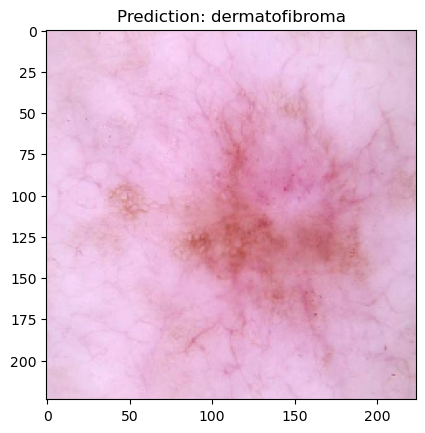

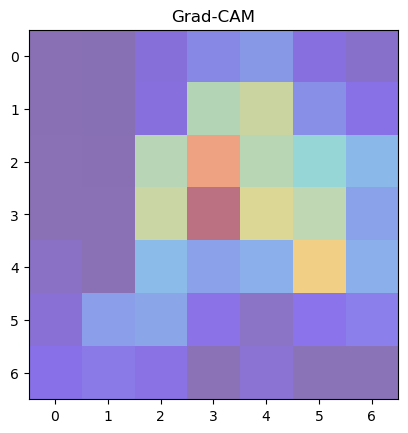

In [23]:
# --- Step 11: Explainability with Grad-CAM ---
def generate_gradcam(model, img_path, layer_name):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.models import Model
    from tensorflow.keras import backend as K

    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    img = plt.imread(img_path)
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.title("Grad-CAM")
    plt.show()

# Example Usage for Grad-CAM and Predictions
predict_on_new_images(
    model, 
    image_paths=[
        r"C:\\Users\\marti\\Desktop\\dom\\Data\\ISIC_0027876.jpg"
        
    ], 
    class_indices=train_generator.class_indices
)

generate_gradcam(
    model, 
    img_path=r"C:\\Users\\marti\\Desktop\\dom\\DAta\\ISIC_0027876.jpg", 
    layer_name="conv5_block3_out"
)
